# 4b. Model met Data Augmentation

In het vorige notebook (Baseline) zagen we dat het model zwaar aan het **overfitten** was: 100% score op training, maar veel lager op validatie.

In dit notebook voegen we **Data Augmentation** toe. Dit houdt in dat we de trainingsafbeeldingen kunstmatig aanpassen (draaien, zoomen, spiegelen) zodat het model nooit twee keer exact hetzelfde ziet. Ook voegen we een **Dropout** laag toe die willekeurig neuronen uitschakelt.

Doel: Het gat tussen training- en validatie-accuracy verkleinen.

## Imports en Setup

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Paden instellen - gebruik het notebook bestand zelf als referentie
NOTEBOOK_DIR = Path(__file__).parent if '__file__' in dir() else Path(os.getcwd())

# Als we in notebooks/ zitten, ga één niveau omhoog
if NOTEBOOK_DIR.name == "notebooks":
    BASE_DIR = NOTEBOOK_DIR.parent
else:
    BASE_DIR = NOTEBOOK_DIR

DATA_DIR = BASE_DIR / "datasets" / "processed"

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "validation"
TEST_DIR = DATA_DIR / "test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print(f"Base directory: {BASE_DIR.resolve()}")
print(f"Data directory: {DATA_DIR.resolve()}")
print(f"Train map bestaat: {TRAIN_DIR.exists()}")

Base directory: /home/mathieu/Documenten/Deep_Learning_Schilderijen
Data directory: /home/mathieu/Documenten/Deep_Learning_Schilderijen/datasets/processed
Train map bestaat: True


## Data laden

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Performance optimalisatie
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1891 files belonging to 4 classes.


Found 408 files belonging to 4 classes.


## Data augmentation

In [17]:
data_augmentation = models.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1), # Max 10% draaien
  layers.RandomZoom(0.1),     # Max 10% inzoomen
], name="data_augmentation")

print("Augmentation laag aangemaakt.")

Augmentation laag aangemaakt.


## Visualisatie van Augmentation

2026-01-01 17:36:34.155682: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


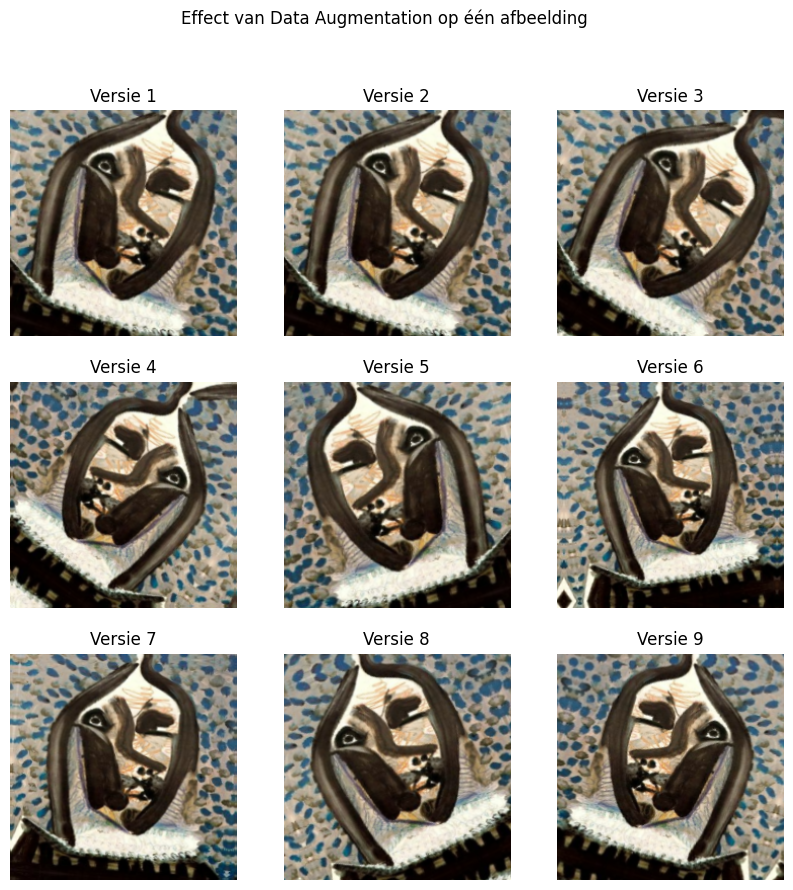

In [18]:
plt.figure(figsize=(10, 10))

# Pak één batch met afbeeldingen
for images, _ in train_ds.take(1):
    # Pak de eerste afbeelding
    first_image = images[0]
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Pas augmentation toe op de afbeelding
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        
        # Plotten (pixelwaarden moeten tussen 0-255 of 0-1 zijn)
        plt.imshow(augmented_image[0] / 255.0)
        plt.axis("off")
        plt.title(f"Versie {i+1}")

plt.suptitle("Effect van Data Augmentation op één afbeelding")
plt.show()

## Het model bouwen

In [19]:
num_classes = 4 # Rembrandt, Picasso, Mondriaan, Rubens

model = models.Sequential([
  layers.Input(shape=(224, 224, 3)),
  
  # 1. Augmentation (Alleen actief tijdens training!)
  data_augmentation,
  
  # 2. Rescaling
  layers.Rescaling(1./255),
  
  # 3. Conv Layers (Zelfde als baseline)
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # 4. Dense Layers
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  
  # 5. Dropout (Nieuw! Tegen overfitting)
  layers.Dropout(0.5), 
  
  layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,756 (24.59 MB)

 Trainable params: 6,446,756 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

## Trainen lokaal

In [20]:
# Lokaal doen we maar 5 epochs om te testen. 
# De echte resultaten voor het verslag komen van de Supercomputer (train_augmentation.py).
epochs = 5 

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 423ms/step - accuracy: 0.5722 - loss: 1.1146 - val_accuracy: 0.6838 - val_loss: 0.8914
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - accuracy: 0.6727 - loss: 0.8660 - val_accuracy: 0.6397 - val_loss: 0.8698
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 420ms/step - accuracy: 0.6811 - loss: 0.8016 - val_accuracy: 0.6250 - val_loss: 1.0199
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 426ms/step - accuracy: 0.7044 - loss: 0.7466 - val_accuracy: 0.6544 - val_loss: 0.9769
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 412ms/step - accuracy: 0.7076 - loss: 0.7138 - val_accuracy: 0.6740 - val_loss: 0.9484


## Lokaal resultaat plotten

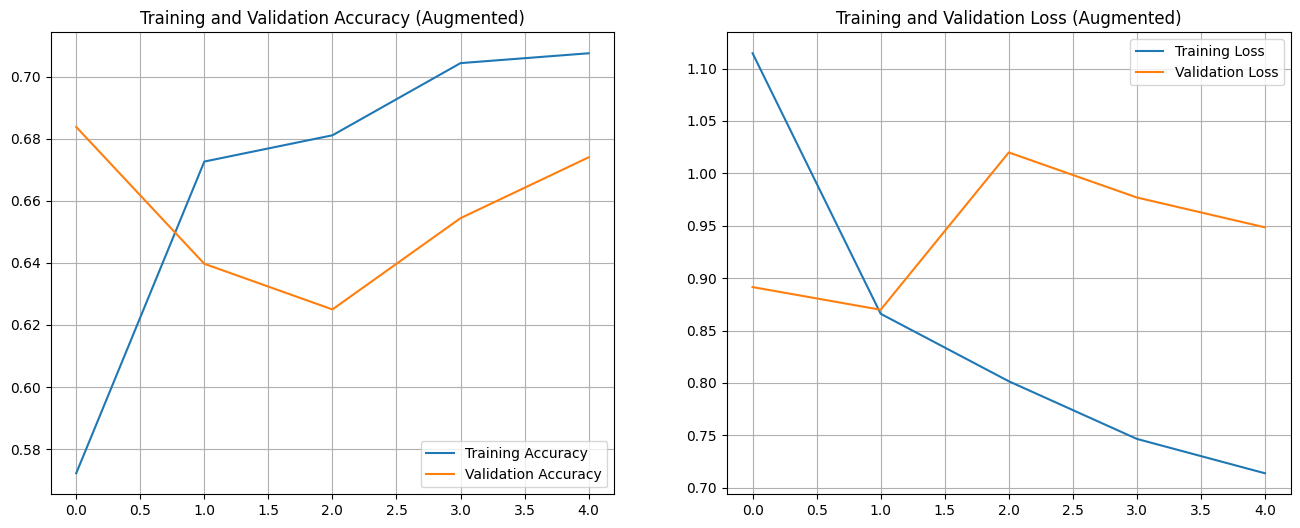

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(16, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Augmented)')
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Augmented)')
plt.grid(True)

plt.show()

We zien hier met 5 epochs niet veel, we kunnen niet veel afleiden dus heb ik dit ook gedaan in VSC met 20 epochs

## Vergelijking lokale resultaten met VSC resultaten

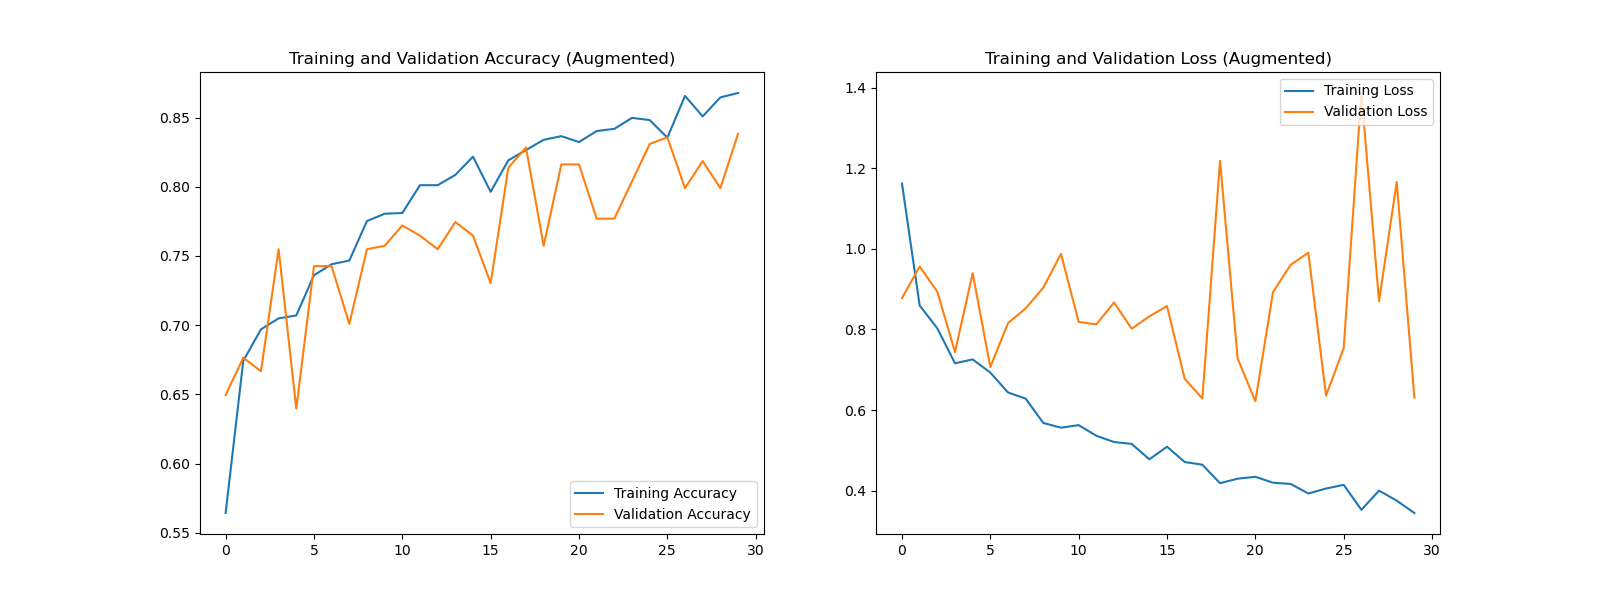

Vanuit de vorige notebook hebben we gezien dat er veel overfitting was, nu zien we dat het augmented model minder overfitting heeft, maar instabiel is.

Bewijs:
    - Als je kijkt naar de blauwe lijn: die eindigt nu rond de 0.87 in plaats van 1.00 in het baseline model. Dat is goed! Het betekent dat de data augmentation het moeilijker maakt voor het model om uit het hoofd te leren.
    - De oranje lijn heeft veel pieken en dalen. Dit komt omdat onze dataset erg klein is. Het model heeft nog altijd moeite om een stabiel patroon te vinden in al die gedraaide en gezoomde versies.

Conclusie: Augmentation helpt tegen het uit het hoofd te leren, maar het model is simpelweg niet slim genoeg om met zo weinig data toch hoge scores te halen.


## Volgende stap

Omdat zelf data augmentation de grens van 95% niet bereikt wordt en de validatie instabiel blijft door de te kleine dataset, is Transfer Learning noodzakelijk. We gaan een model (bv VGG16) gebruiken dat al getraind is op miljoenen afbeeldingen.